In [1]:
from repepo.experiments.steering.utils.helpers import (
    SteeringConfig,
    SteeringResult,
    load_results,
    list_subset_of_datasets,
    get_steering_configs_for_datasets
)

datasets = ['sycophancy_train']
configs = get_steering_configs_for_datasets(
    datasets,
    train_split_name = "train-dev",
    test_split_name = "val-dev",
)

all_results = []
for config in configs:
    results = load_results(config)
    print(len(results))
    all_results.append((config, results))
    

544


### 1.1 Plot Steering Performance

Steering performance is measured in terms of the mean logit difference between (positive answer token) and (negative answer token)

In [2]:
import matplotlib.pyplot as plt 

def _get_title(config: SteeringConfig):
    return (
        f"{config.train_dataset_name}-"
        f"{config.train_split_name}-"
        f"{config.test_dataset_name}-"
        f"{config.test_split_name}"
    ) 

def plot_in_distribution_data_for_layer(
    ax,
    config: SteeringConfig,
    results: list[SteeringResult]
):

    for layer in config.layers:
        layer_results = [x for x in results if x.layer_id == layer]
        layer_results.sort(key=lambda x: x.multiplier)
        ax.plot(
            [x.multiplier for x in layer_results],
            [x.logit_diff for x in layer_results],
            label=f"Layer {layer}",
            marker="o",
            linestyle="dashed",
            markersize=5,
            linewidth=2.5,
        )

    # ax.set_ylim(0,1)
    ax.legend()
    ax.set_title(_get_title(config))
    ax.set_xlabel("Multiplier")
    ax.set_ylabel("Mean logit difference")

/tmp/ipykernel_3659520/999538259.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


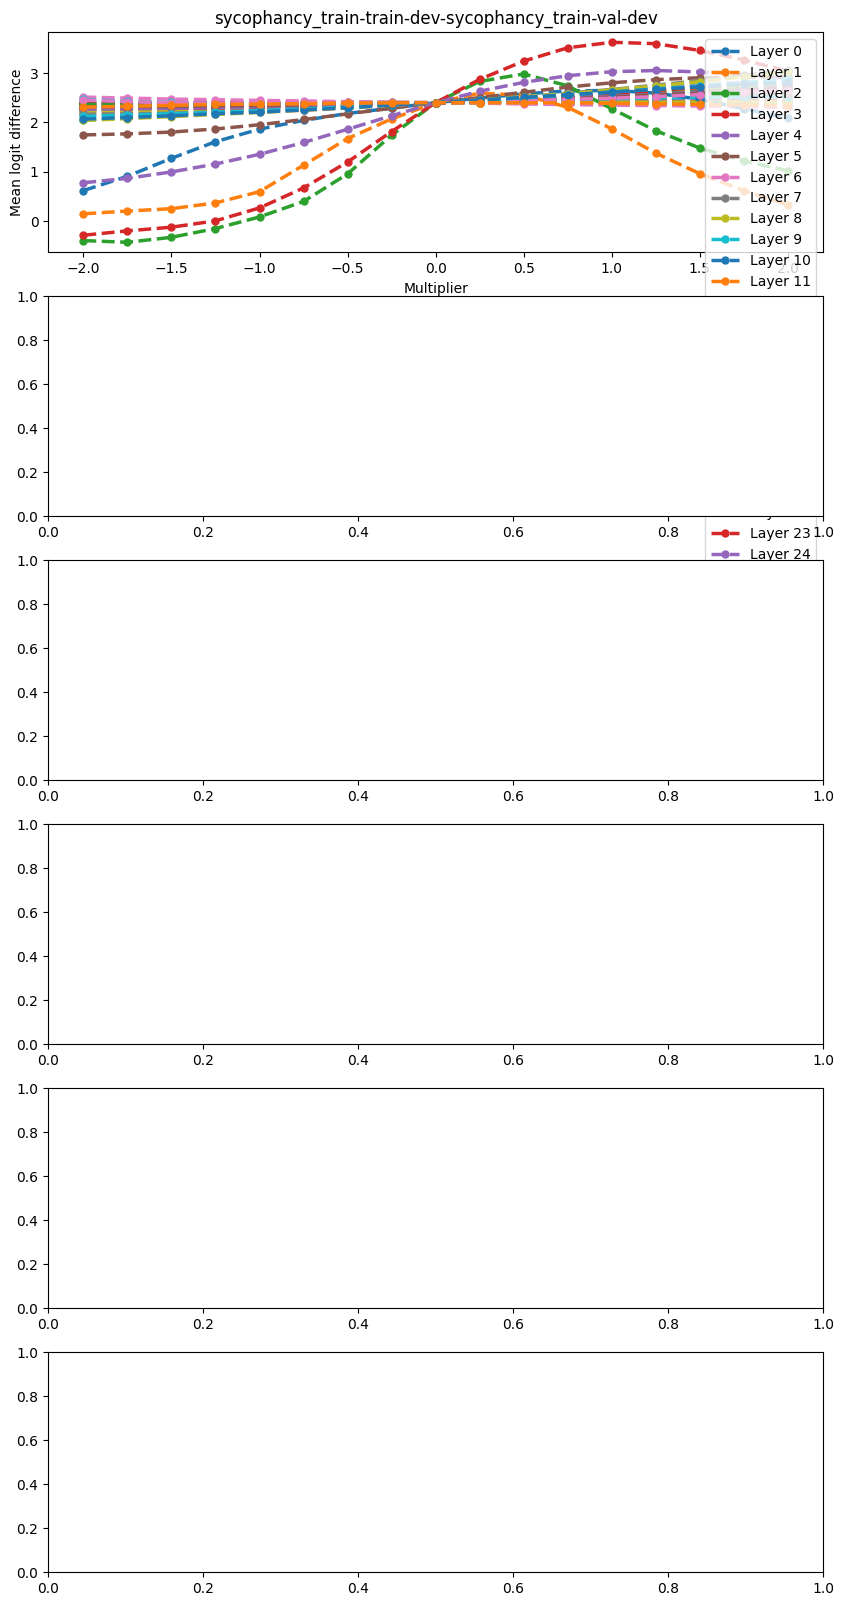

In [3]:
# Create figure
fig, axs = plt.subplots(6, 1, figsize=(10, 20))

for i, (config, results) in enumerate(all_results):
    ax = axs[i]
    plot_in_distribution_data_for_layer(ax, config, results)

fig.tight_layout()
plt.show()

### 1.2 Compute Steering Efficiency

Steering efficiency is computed as the slope of the linear regression line
- where X is the multiplier
- and Y is the mean-logit difference

Text(0, 0.5, 'Slope of best-fit line')

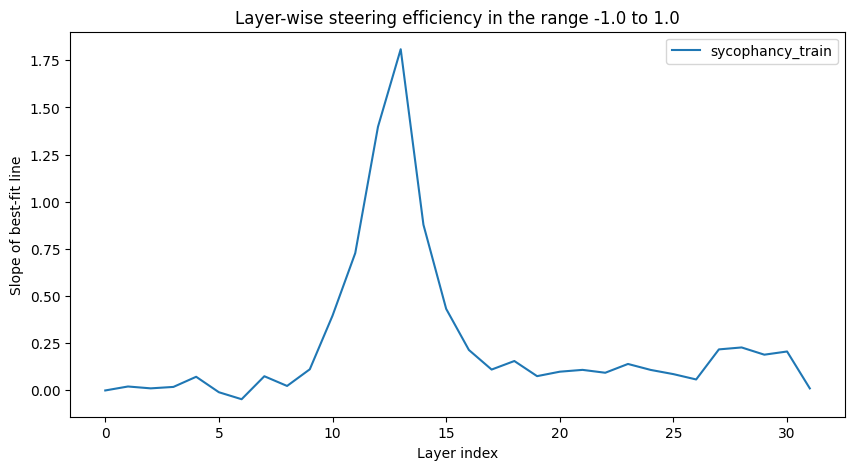

In [4]:
import numpy as np
from typing import NewType

multiplier_lower_bound = -1.0
multiplier_upper_bound = 1.0
DatasetName = NewType("DatasetName", str)

layers = tuple(configs[0].layers)

all_slopes: dict[DatasetName, np.ndarray] = {}
for config in configs:
    result = load_results(config)
    _layers = tuple(config.layers)
    assert _layers == layers, "Layers must be the same for all configs"

    slopes = []
    for layer in layers:
        # Calculate slope of best-fit line within range (-1, 1)
        layer_results = [x for x in result if x.layer_id == layer]
        layer_results.sort(key=lambda x: x.multiplier)
        layer_results = [x for x in layer_results if multiplier_lower_bound <= x.multiplier <= multiplier_upper_bound]
        x = [x.multiplier for x in layer_results]
        y = [x.logit_diff for x in layer_results]
        m, b = np.polyfit(x, y, 1)
        slopes.append(m)
    slopes  = np.array(slopes)
    all_slopes[config.train_dataset_name] = slopes

# Plot slopes by layer 
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
for dataset_name, slopes in all_slopes.items():
    axs.plot(layers, slopes, label=dataset_name)
axs.legend()
axs.set_title("Layer-wise steering efficiency in the range {} to {}".format(multiplier_lower_bound, multiplier_upper_bound))
axs.set_xlabel("Layer index")
axs.set_ylabel("Slope of best-fit line")


## 2. Correlate steering performance with metrics

- Pairwise cosine similarity gives us a notion of "variance in direction" 
- Variance of norms gives us a notion of "variance in magnitude"
- Mean (scaled) euclidean distance to the mean-diff-vec is a notion of both

['variance_of_norm_scaled_mean_norm', 'euclidean_scaled_mean_norm', 'cosine']


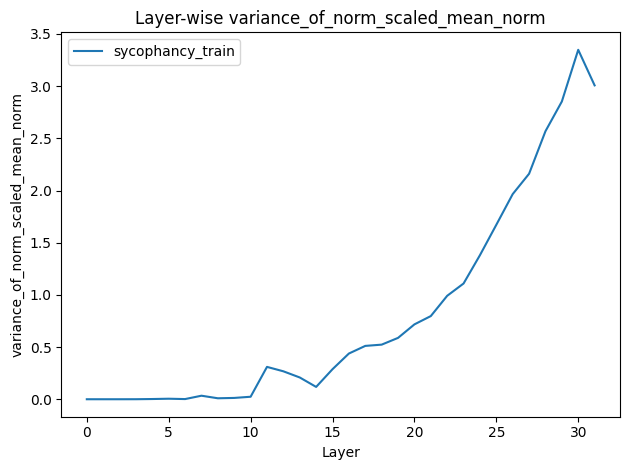

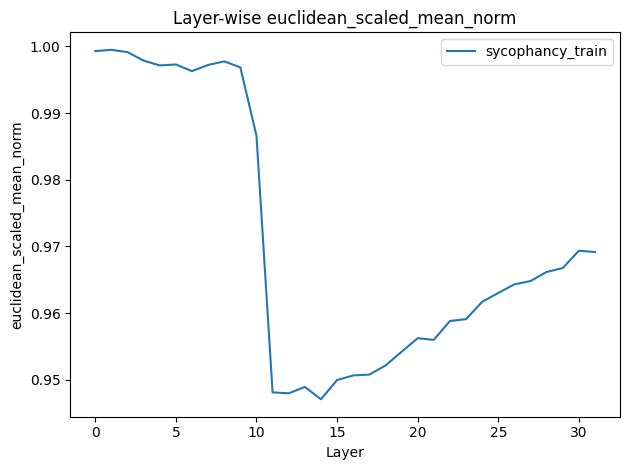

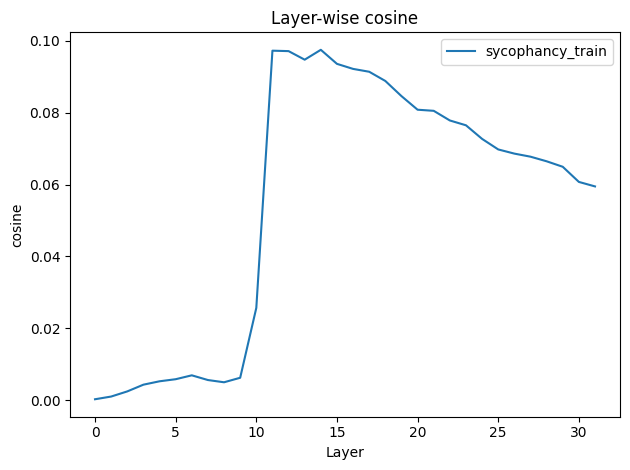

In [5]:
from repepo.experiments.steering.utils.metrics import list_metrics
from repepo.experiments.steering.utils.notebook_utils import (
    get_all_metrics, 
    get_all_concept_vectors, 
    plot_all_metrics, 
)

metric_names = list_metrics()
print(metric_names)

for metric_name in metric_names:
    plot_all_metrics(configs, metric_name)


### 2.2 Visualize correlations between metrics, steering efficiency

In [6]:
# Create dict of (dataset) x 10 matrices for metrics
import numpy as np
matrices: dict[str, np.ndarray] = {}

slopes_mat = np.zeros(shape = (len(all_slopes), len(layers)))
for i, (dataset_name, slopes) in enumerate(all_slopes.items()):
    slopes_mat[i] = slopes
matrices["steering_efficiency"] = slopes_mat 

In [8]:
for metric_name in metric_names:
    metrics = get_all_metrics(configs, metric_name)
    # assert len(metrics) == 6
    # assert len(layers) == 10
    metrics_mat = np.zeros(shape = (len(metrics), len(layers)))
    for i, (dataset_name, layerwise_metrics) in enumerate(metrics.items()):
        metric_values = [layerwise_metrics[k] for k in layers]
        metrics_mat[i] = np.array(metric_values)
    
    matrices[metric_name] = metrics_mat

# Invert the cosine similarity
# matrices["cosine"] = - matrices["cosine"]
# matrices["dot_product"] = matrices["dot_product"]


[[1.         0.99706745 0.73093842]
 [0.99706745 1.         0.72983871]
 [0.73093842 0.72983871 1.        ]]


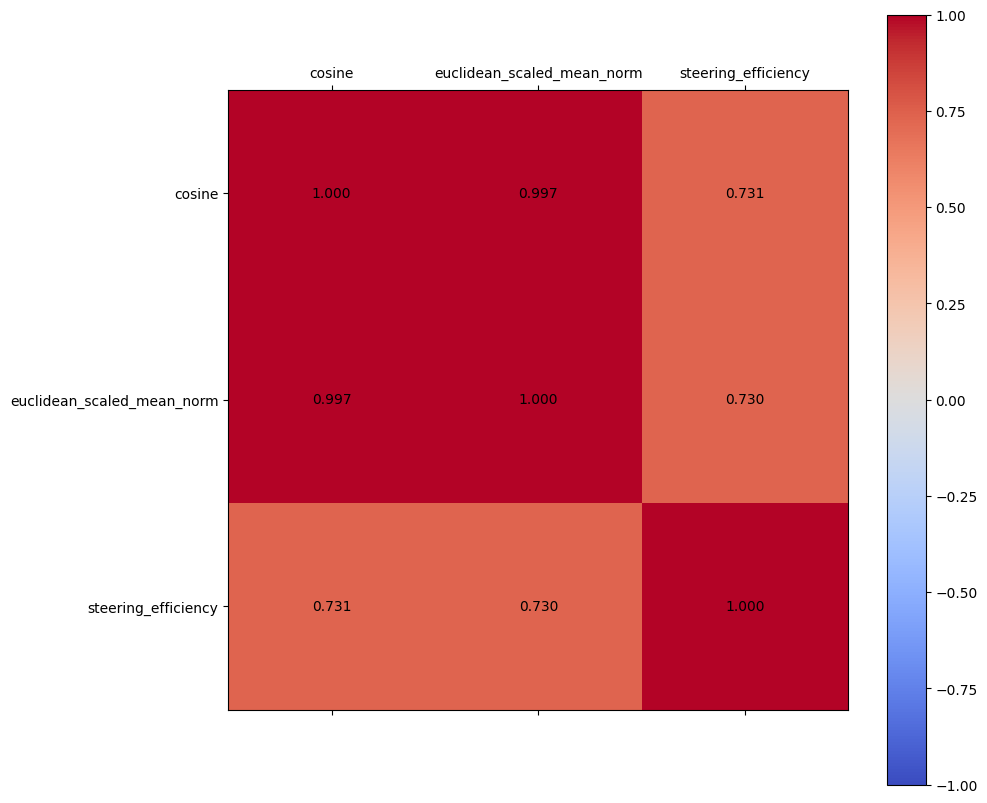

In [9]:

flattened_matrices = {k: v.flatten() for k, v in matrices.items()}
_to_keep = (
    "cosine",
    "euclidean_scaled_mean_norm",
    "steering_efficiency"
)
flattened_matrices = {k: flattened_matrices[k] for k in _to_keep}

# Invert the variances to make them into similarity metrics
flattened_matrices["euclidean_scaled_mean_norm"] = -flattened_matrices["euclidean_scaled_mean_norm"]
# flattened_matrices["unscaled_var"] = -flattened_matrices["unscaled_var"]


# Compute spearman correlation between each pair of metrics
from scipy.stats import spearmanr
correlation_matrix = np.zeros(shape = (len(flattened_matrices), len(flattened_matrices)))
for i, (name1, mat1) in enumerate(flattened_matrices.items()):
    for j, (name2, mat2) in enumerate(flattened_matrices.items()):
        rho, p = spearmanr(mat1, mat2)
        correlation_matrix[i, j] = rho

# Plot correlation matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cax = ax.matshow(correlation_matrix, cmap="coolwarm", clim=(-1, 1))
# Axis labels using _to_keep 
ax.set_xticks(range(len(_to_keep)))
ax.set_yticks(range(len(_to_keep)))
ax.set_xticklabels(_to_keep)
ax.set_yticklabels(_to_keep)

# Add values 
for i in range(len(_to_keep)):
    for j in range(len(_to_keep)):
        ax.text(i, j, f"{correlation_matrix[j, i]:.3f}", ha="center", va="center", color="black")


fig.colorbar(cax)


print(correlation_matrix)